# Nearest Neighbours

#### Here we have a function which allows us to find the nearest neighbours of a person given either their attributes, or their iid number

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../data/Speed Dating Data.csv')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [3]:
# need this to get age in the same format (1-10) as other attributes. 
# Can also go from 1-10 to original age if direction='backward'
def rescale_age(age, direction="forward"):
    ser = df['age'] 
    if direction.lower() == 'forward':
        result = (10 - 1) / (ser.max() - ser.min()) * (age - ser.min()) + 1
    elif direction.lower() == 'backward':     
        result = (age - 1) * (ser.max() - ser.min()) / (10. - 1) + ser.min()
    return result

In [4]:
# Get a subsetted dataframe grouped by iid
cols = ['iid', 'gender']
atts = ['age', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o']
interests = ['sports','tvsports','exercise','dining','museums','art','hiking',
             'gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
model_df = df[atts+cols]
# rescale age to be between 1 and 10
model_df['age'] = rescale_age(model_df['age'])

model_df = model_df.dropna(how='all')
model_df = model_df.groupby('iid').mean()
model_df.reset_index(inplace=True)
model_df.head()

c:\python27\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,iid,age,attr_o,sinc_o,intel_o,fun_o,amb_o,gender
0,1,1.729730,6.7,7.4,8.0,7.2,8.000000,0
1,2,2.459459,7.7,7.1,7.9,7.5,7.500000,0
2,3,2.702703,6.5,7.1,7.3,6.2,7.111111,0
3,4,2.216216,7.0,7.1,7.7,7.5,7.700000,0
4,5,1.729730,5.3,7.7,7.6,7.2,7.800000,0


In [5]:
# this function takes in a pandas series of attributes OR an iid and returns a new dataframe ordered by the people who are most
# similar to a person with those attributes or iid
def nearest_neighbours(att_series=pd.Series(), iid_val=None):
    if not att_series.empty:
        # subsets model_df to a df with only the same sex as in att_series
        gender_df = model_df[model_df['gender'] == att_series['gender']]
        # rescale age to 1-10
        att_series['age'] = rescale_age(att_series['age'])
        
        sub_att_series = att_series.drop('gender', axis=0)
        difference_2Darray = gender_df[atts].values - sub_att_series.values
        
    elif iid_val:
        iid_gender = model_df.loc[model_df['iid'] == iid_val, 'gender']
        gender_df = model_df[model_df['gender'] == iid_gender]
        
        difference_2Darray = (gender_df[atts].values - model_df[model_df['iid'] == iid_val][atts].values)
    else:
        print "You didn't enter an iid value OR an attribute series"
        
    distance_1Darray = np.sum(np.square(difference_2Darray), axis=1)

    df2=gender_df.copy()
    df2['dist'] = distance_1Darray
    df2['age'] = rescale_age(df2['age'], 'backward')
    df2.sort_values('dist', inplace=True)
    return df2

In [17]:
# Just change these Series values if you want to play around
my_atts = pd.Series([1, 36, 7, 6, 8, 5, 6], index=['gender', 'age', 'attr', 'sinc', 'intel', 'fun', 'amb'])
# my_iid = 10

nearest_neighbours(att_series=my_atts).head()

,iid,age,attr_o,sinc_o,intel_o,fun_o,amb_o,gender,dist
288,290,34.0,6.571429,6.333333,7.523810,5.380952,6.380952,1,0.823479
506,508,36.0,5.833333,5.666667,6.833333,5.333333,6.500000,1,3.337615
546,548,30.0,6.857143,5.809524,6.666667,5.714286,6.150000,1,3.535908
545,547,30.0,6.318182,6.181818,7.045455,6.045455,6.272727,1,3.745183
163,165,30.0,7.375000,7.062500,6.812500,5.600000,5.785714,1,4.254342


In [18]:
neighbour_ids = nearest_neighbours(att_series=my_atts).head(2)['iid'].values
print neighbour_ids

[275 123]


In [19]:
# Now if you want to find more information about the person of a particular iid, just search in the original df:
dopple_df = df[df['iid'].isin(neighbour_ids)][['iid', 'pid', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o']]

In [20]:
# get the people that said yes to the neighbours
id_list = dopple_df[dopple_df['dec_o'] == 1]['pid'].values
# dopple_df[dopple_df['dec_o'] == 1]
id_list

array([ 114.,  116.,  119.,  121.,  261.])

In [21]:
# Find the mean of each attribute/interest for a whole gender
mean_df = df[cols+atts+interests][df['gender']==0].mean()
mean_df

iid         275.430210
gender        0.000000
age          26.105851
attr_o        6.461401
sinc_o        7.251053
intel_o       7.291202
fun_o         6.520164
amb_o         6.604591
sports        5.813333
tvsports      4.162424
exercise      6.450909
dining        8.147152
museums       7.428364
art           7.219636
hiking        5.942061
gaming        3.302303
clubbing      5.899879
reading       7.907152
tv            5.739394
theater       7.481939
movies        8.198061
concerts      7.103758
music         7.989576
shopping      6.499152
yoga          4.989818
dtype: float64

In [22]:
# Get the mean of the attributes/interests of all the people that said yes to ALL of our nearest neighbours
person_df = df[cols+atts+interests][df['iid'].isin(id_list)]
person_means = person_df.groupby('iid').mean()
# Compare with the mean_df above
difference_ser = person_means.mean() - mean_df
# print info_list.append(person_df.mean())
difference_ser

age        -4.705851
amb_o      -0.533947
art         0.780364
attr_o     -0.524258
clubbing    1.900121
concerts    1.896242
dining      0.252848
exercise   -1.850909
fun_o      -0.730164
gaming      1.297697
gender      0.000000
hiking     -0.942061
iid              NaN
intel_o    -0.293107
movies      0.801939
museums     0.171636
music       1.610424
reading     0.692848
shopping    0.100848
sinc_o     -0.445497
sports     -0.413333
theater     1.518061
tv          0.660606
tvsports    0.437576
yoga        0.610182
dtype: float64

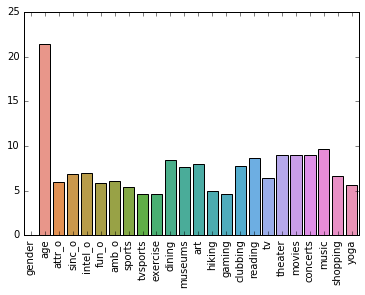

In [32]:
x = person_means.mean().index
y = person_means.mean().values
ax = sns.barplot(x, y)
ax.set_xticklabels(labels=x, rotation=90)

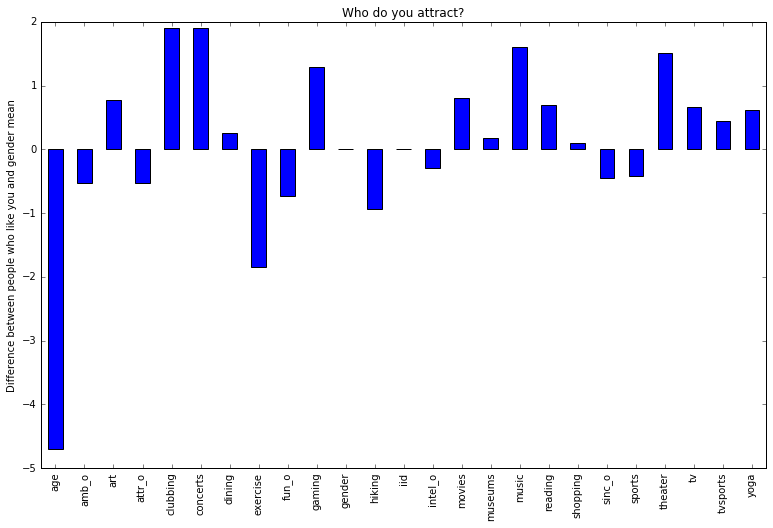

In [23]:
ax = difference_ser.plot(kind='bar', figsize=(13,8), title='Who do you attract?')
ax.set_ylabel('Difference between people who like you and gender mean')

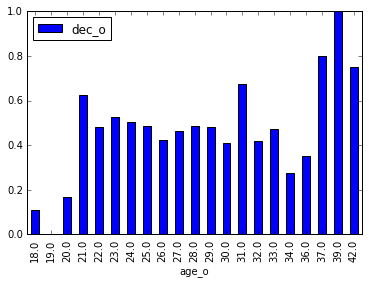

In [13]:
# As a side, let's look at the number of yeses per age
#MEN:

age_yes_df = df[['gender','age_o', 'dec_o']][df['gender']==0]
age_yes_df = age_yes_df[['age_o', 'dec_o']].groupby('age_o').mean()
age_yes_df.plot(kind='bar')

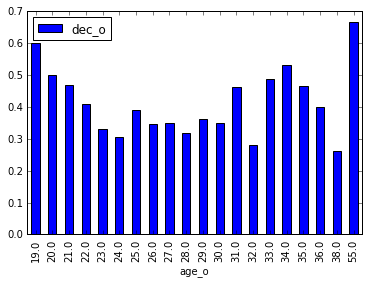

In [14]:
#WOMEN:

age_yes_df = df[['gender','age_o', 'dec_o']][df['gender']==1]
age_yes_df = age_yes_df[['age_o', 'dec_o']].groupby('age_o').mean()
age_yes_df.plot(kind='bar')